In [2]:
import math
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt 
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [3]:
tracking_2018_df = pd.read_csv("tracking2018.csv")
tracking_2019_df = pd.read_csv("tracking2019.csv")
tracking_2020_df = pd.read_csv("tracking2020.csv")
tracking_df = pd.concat([tracking_2018_df, tracking_2019_df, tracking_2020_df], axis=0)

tracking_df = tracking_df.drop(["time", "displayName", "jerseyNumber", "playDirection"], axis=1)
tracking_df.head()

,x,y,s,a,dis,o,dir,event,nflId,position,team,frameId,gameId,playId
0,41.32,29.45,4.36,1.33,0.43,130.42,128.44,None,39470.0,K,home,1,2018123000,36
1,41.68,29.17,4.59,1.24,0.45,128.59,127.81,None,39470.0,K,home,2,2018123000,36
2,42.05,28.88,4.74,0.99,0.47,124.47,128.15,None,39470.0,K,home,3,2018123000,36
3,42.43,28.59,4.87,0.71,0.48,126.02,127.35,None,39470.0,K,home,4,2018123000,36
4,42.84,28.31,4.96,0.79,0.50,131.71,124.75,None,39470.0,K,home,5,2018123000,36


In [4]:
tracking_df = tracking_df.dropna(subset=['nflId'])
tracking_df["nflId"] = tracking_df["nflId"].astype(int)
tracking_single_df = tracking_df.loc[tracking_df["event"] == "kick_received"]
tracking_single_df = tracking_single_df.drop(["event"], axis=1)

In [6]:
WIDTH = 120
HEIGHT = 53.3

def reflect_x(x):
    return (360 - x)

def reflect_y(y):
    return (540 - y) % 360

def get_train_data(train_kickoff_df):
    valid_indices = get_valid_indices(train_kickoff_df)
    
    X_train = np.empty((len(valid_indices) * 2, 11, 10, 10))
    Y_train = np.zeros((len(valid_indices) * 2, 209))
    indices = train_kickoff_df.index
    for i in range(len(valid_indices)):
        index = valid_indices[i]
        play_df = tracking_single_df.loc[(tracking_single_df["gameId"] == indices[index][0]) & 
                                    (tracking_single_df["playId"] == indices[index][1])]

        returner = int(train_kickoff_df.iloc[index]["returnerId"].split(";")[0])
        offense = play_df.loc[play_df["nflId"] == returner]["team"].values[0]
        offense_df = play_df.loc[play_df["team"] == offense].reset_index()
        returner_df = offense_df.loc[offense_df["nflId"] == returner]
        offense_df = offense_df.drop(offense_df[offense_df['nflId'] == returner].index).reset_index()
        defense_df = play_df.loc[play_df["team"] != offense].reset_index()
        r_row = returner_df.iloc[0]

        normal_data = np.empty((11, 10, 10))
        augmented_y_data = np.empty((11, 10, 10))
        for j, d_row in defense_df.iterrows():
            normal = np.empty((10, 10))
            augmented_y = np.empty((10, 10))
            for k, o_row in offense_df.iterrows():
                # Defense Sx,Sy
                normal[0][k] = math.sin(d_row["dir"] * math.pi/180) * d_row["s"]
                normal[1][k] = math.cos(d_row["dir"] * math.pi/180) * d_row["s"]
                augmented_y[0][k] = math.sin(d_row["dir"] * math.pi/180) * d_row["s"]
                augmented_y[1][k] = math.cos(reflect_y(d_row["dir"]) * math.pi/180) * d_row["s"]

                # Defense X,Y - Returner X,Y
                normal[2][k] = d_row["x"] - r_row["x"]
                normal[3][k] = d_row["y"] - r_row["y"]
                augmented_y[2][k] = d_row["x"] - r_row["x"]
                augmented_y[3][k] = (HEIGHT - d_row["y"]) - (HEIGHT - r_row["y"])

                # Defense Sx,Sy - Returner Sx,Sy
                normal[4][k] = math.sin(d_row["dir"] * math.pi/180) * d_row["s"] - math.sin(r_row["dir"] * math.pi/180) * r_row["s"]
                normal[5][k] = math.cos(d_row["dir"] * math.pi/180) * d_row["s"] - math.cos(r_row["dir"] * math.pi/180) * r_row["s"]
                augmented_y[4][k] = math.sin(d_row["dir"] * math.pi/180) * d_row["s"] - math.sin(r_row["dir"] * math.pi/180) * r_row["s"]
                augmented_y[5][k] = math.cos(reflect_y(d_row["dir"]) * math.pi/180) * d_row["s"] - math.cos(reflect_y(r_row["dir"]) * math.pi/180) * r_row["s"]
                
                # Offense X,Y - Defense X,Y
                normal[6][k] = o_row["x"] - d_row["x"]
                normal[7][k] = o_row["y"] - d_row["y"]
                augmented_y[6][k] = o_row["x"] - d_row["x"]
                augmented_y[7][k] = (HEIGHT - o_row["y"]) - (HEIGHT - d_row["y"])

                # Offense Sx,Sy - Defense Sx,Sy
                normal[8][k] = math.sin(o_row["dir"] * math.pi/180) * o_row["s"] - math.sin(d_row["dir"] * math.pi/180) * d_row["s"]
                normal[9][k] = math.cos(o_row["dir"] * math.pi/180) * o_row["s"] - math.cos(d_row["dir"] * math.pi/180) * d_row["s"]
                augmented_y[8][k] = math.sin(o_row["dir"] * math.pi/180) * o_row["s"] - math.sin(d_row["dir"] * math.pi/180) * d_row["s"]
                augmented_y[9][k] = math.cos(reflect_y(o_row["dir"]) * math.pi/180) * o_row["s"] - math.cos(reflect_y(d_row["dir"]) * math.pi/180) * d_row["s"]
            
            normal_data[j] = normal
            augmented_y_data[j] = augmented_y

        X_train[i] = normal_data
        X_train[i + 1] = augmented_y_data
        yards = int(train_kickoff_df.iloc[index]["kickReturnYardage"])
        Y_train[i: i + 2, yards + 99:] = np.ones((1, 110 - yards))

    return torch.DoubleTensor(X_train), torch.DoubleTensor(Y_train)

def get_kickoff_plays():
    kickoff_df = all_plays_df.loc[(all_plays_df['specialTeamsPlayType'] == "Kickoff") & (all_plays_df["specialTeamsResult"] == "Return")]
    kickoff_df = kickoff_df.set_index(["gameId", "playId"])
    kickoff_df = kickoff_df.drop(["playDescription", "down", "yardsToGo", "kickBlockerId",
                              "yardlineNumber", "yardlineSide", "gameClock", "penaltyCodes", "penaltyJerseyNumbers",
                              "penaltyYards", "specialTeamsPlayType", "specialTeamsResult", "preSnapHomeScore",
                              "preSnapVisitorScore", "passResult", "absoluteYardlineNumber", "playResult"], axis=1)
    
    pff_indexed_df = pff_df.set_index(["gameId", "playId"])
    kickoff_df = pd.concat([kickoff_df, pff_indexed_df], axis=1, join='inner')
    kickoff_df = kickoff_df.drop(["snapDetail", "snapTime", "operationTime", "gunners", "puntRushers", "vises", 
                                 "kickContactType", "missedTackler", "assistTackler", "tackler",
                                  "returnDirectionActual", "specialTeamsSafeties"], axis=1)

    kickoff_df = kickoff_df.dropna(subset=['kickReturnYardage', 'returnerId'])
    return kickoff_df

def get_valid_indices(df):
    indices = df.index
    valid_indices = []
    for i in range(len(indices)):
        play_df = tracking_single_df.loc[(tracking_single_df["gameId"] == indices[i][0]) & 
                                    (tracking_single_df["playId"] == indices[i][1])]
        if not play_df.empty:
            valid_indices.append(i)
    return valid_indices

all_plays_df = pd.read_csv("plays.csv")
pff_df = pd.read_csv("PFFScoutingData.csv")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kickoff_df = get_kickoff_plays()
X, Y = get_train_data(kickoff_df)

In [27]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2)

In [23]:
class Lambda(nn.Module):
    def __init__(self, lambd):
        super(Lambda, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return (self.lambd)(x)

class Add(nn.Module):
    def __init__(self):
        super(Add, self).__init__()
    def forward(self, x, y):
        return x + y
    
class ERYNet(nn.Module):
    def __init__(self):
        super(ERYNet, self).__init__()
                
        self.block1 = nn.Sequential(
            nn.Conv2d(11, 128, kernel_size=(1,1), stride=(1,1)),
            nn.ReLU(),
            nn.Conv2d(128, 160, kernel_size=(1,1),  stride=(1,1)),
            nn.ReLU(),
            nn.Conv2d(160, 128, kernel_size=(1,1),  stride=(1,1)),
            nn.ReLU()
        )
        
        self.maxpool2d = nn.MaxPool2d(kernel_size=(1, 10))
        self.lambda1 = Lambda(lambda x: x * 0.3)
        self.avgpool2d = nn.AvgPool2d(kernel_size=(1, 10))
        self.lambda2 = Lambda(lambda x: x * 0.7)
        self.add = Add()
        self.norm2d = nn.BatchNorm2d(128)
        self.squeeze1 = Lambda(lambda x : torch.squeeze(x,3))
            
        self.block2 = nn.Sequential(
            nn.Conv1d(128, 160, kernel_size=1, stride=1),
            nn.ReLU(),
            nn.BatchNorm1d(160),
            nn.Conv1d(160, 96, kernel_size=1,  stride=1),
            nn.ReLU(),
            nn.BatchNorm1d(96),
            nn.Conv1d(96, 96, kernel_size=1,  stride=1),
            nn.ReLU(),
            nn.BatchNorm1d(96)
        )
        
        self.maxpool1d = nn.MaxPool1d(kernel_size=10)
        self.avgpool1d = nn.AvgPool1d(kernel_size=10)
        self.squeeze2 = Lambda(lambda x : torch.squeeze(x,2))
        
        self.block3 = nn.Sequential(
            nn.Linear(96, 96),
            nn.ReLU(),
            nn.BatchNorm1d(96),
            nn.Linear(96, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 209),
            nn.Softmax()
        )
    
    def forward(self, x):
        x = self.block1(x)
        xmax = self.maxpool2d(x)
        xmax = self.lambda1(xmax)
        xavg = self.avgpool2d(x)
        xavg = self.lambda2(xavg)
        x = self.add(xmax, xavg)
        x = self.norm2d(x)
        x = self.squeeze1(x)

        x = self.block2(x)
        xmax = self.maxpool1d(x)
        xmax = self.lambda1(xmax)
        xavg = self.avgpool1d(x)
        xavg = self.lambda2(xavg)
        x = self.add(xmax, xavg)
        x = self.squeeze2(x)

        x = self.block3(x)
        return x
    
def crps(y_true, y_pred):
    return torch.mean(torch.square(y_true - torch.cumsum(y_pred, axis=1)), dim=1)

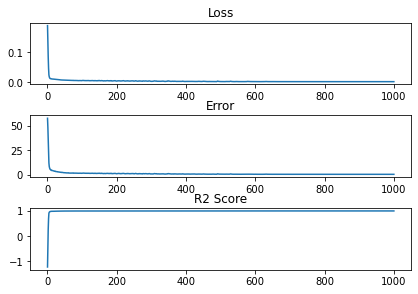

Train Loss: 0.0024562908802181482
Train Error: 0.5131158220258867
Train R2 Score: 0.999751780958419


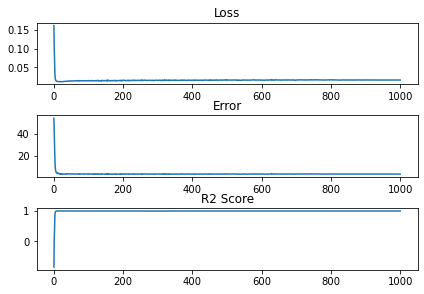

Test Loss: 0.015399854132597543
Test Error: 3.3743715164764723
Test R2 Score: 0.9861402540134462


In [31]:
def train(model, num_epochs, batch_size, X_train, Y_train, X_valid, Y_valid):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, total_steps=num_epochs)

    epochs = []
    losses = []
    errors = []
    r2_scores = []
    valid_losses = []
    valid_errors = []
    valid_r2_scores = []
    num_samples = X_train.size()[0]
    for epoch in range(num_epochs):
        model.train()
        shuffled_indices = torch.randperm(num_samples)
        y_true = torch.empty((num_samples, 209)).to(device)
        y_pred = torch.empty((num_samples, 209)).to(device)
        for i in range(0, num_samples, batch_size):
            optimizer.zero_grad()
            indices = shuffled_indices[i: i + batch_size]
            batch_x, batch_y = X_train[indices], Y_train[indices]
            pred = model.forward(batch_x)
            loss = sum(crps(batch_y, pred))
            loss.backward()
            optimizer.step()

            y_true[i: i + batch_size] = batch_y
            y_pred[i: i + batch_size] = pred
        
        epochs.append(epoch + 1)
        losses.append(torch.mean(crps(y_true, y_pred)).item())
        expected_yards = calculate_expected_yards(y_pred)            
        actual_yards = (y_true <= 0).sum(dim=1) - 99.0
        errors.append(torch.mean(torch.abs(actual_yards - expected_yards)).item())
        r2_scores.append(r2_score(actual_yards, expected_yards).item())
        valid_loss, valid_error, valid_r2_score = valid(model, X_valid, Y_valid)
        valid_losses.append(valid_loss)
        valid_errors.append(valid_error)
        valid_r2_scores.append(valid_r2_score)
        scheduler.step()

    show_results(epochs, losses, errors, r2_scores)
    show_results(epochs, valid_losses, valid_errors, valid_r2_scores, valid=True)

def r2_score(y_true, y_pred):
    target_mean = torch.mean(y_true)
    ss_tot = torch.sum((y_true - target_mean) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def calculate_expected_yards(prediction):
    expected_yards = torch.DoubleTensor([i for i in range(-99, 110)]).to(device)
    return (expected_yards * prediction).sum(dim=1)

def valid(model, X_valid, Y_valid):
    model.eval()
    with torch.no_grad():            
        prediction = model(X_valid)
        loss = torch.mean(crps(Y_valid, prediction)).item()
        expected_yards = calculate_expected_yards(prediction)            
        actual_yards = (Y_valid <= 0).sum(dim=1) - 99.0
        error = torch.mean(torch.abs(actual_yards - expected_yards)).item()
        score = r2_score(actual_yards, expected_yards).item()
        return loss, error, score

def show_results(epochs, losses, errors, r2_scores, valid=False):
    figure, axis = plt.subplots(3)
    figure.tight_layout(pad=1.0)
    axis[0].plot(epochs, losses)
    axis[0].set_title("Loss")
    axis[1].plot(epochs, errors)
    axis[1].set_title("Error")
    axis[2].plot(epochs, r2_scores)
    axis[2].set_title("R2 Score")
    plt.show()

    if valid:
        print("Validation Loss:", losses[-1])
        print("Validation Error:", errors[-1])
        print("Validation R2 Score:", r2_scores[-1])
    else:
        print("Train Loss:", losses[-1])
        print("Train Error:", errors[-1])
        print("Train R2 Score:", r2_scores[-1])

model = ERYNet().to(device).double()
num_epochs = 500
batch_size = 64
train(model, num_epochs, batch_size, X_train, Y_train, X_valid, Y_valid)

In [33]:
def predict(samples):
    model.eval()
    with torch.no_grad():            
        prediction = model(samples)
        expected_yards = calculate_expected_yards(prediction)
        return expected_yards